# EX 3 using TF

## Set up

In [1]:
# install packages
# !pip install jiwer
# !pip install pandas
# !pip install matplotlib
# !pip install sentence-


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

import torch
device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


%matplotlib inline

cpu


## Data Prep
### Load Data

In [3]:
data_path = "/home/slimlab/Downloads/LJSpeech-1.1"
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ031-0063,When Dr. Perry noted free air and blood in the...
1,LJ035-0087,Baker required fifteen seconds after the simul...
2,LJ007-0237,Many rats also come through these so-called ve...


### Split Data

In [4]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


### Character ↔️ Number Function

In [5]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [6]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data encoding function
takes in a pice of audio and a trancript and outputs a spectrogram of the audio with the encoded transcript

In [7]:
from tensorflow.python.ops.gen_spectral_ops import fft
# int. scalar tensor. window length in samples
frame_length = 256
# int. scalar tensor. number of samples to step
frame_step = 160
# int scalar tensor. size of FFT
fft_length = 384

def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float, this step might not be necessary
    audio = tf.cast(audio, tf.float32)

    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, 
        frame_length=frame_length, 
        frame_step=frame_step, 
        fft_length=fft_length
    )

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)

    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [8]:
encode_single_sample(metadata_df.file_name[0], metadata_df.normalized_transcription[0])


(<tf.Tensor: shape=(1294, 193), dtype=float32, numpy=
 array([[ 1.3358693 ,  1.9526734 ,  2.681462  , ..., -0.6647458 ,
         -0.72287226, -0.7632472 ],
        [ 2.7958698 ,  3.108681  ,  3.332125  , ..., -0.6319726 ,
         -0.68548155, -0.6811463 ],
        [ 0.5848574 ,  0.06707831,  1.6397213 , ..., -0.3635062 ,
         -0.364336  , -0.3644638 ],
        ...,
        [ 2.6189184 ,  3.3417542 ,  4.2875934 , ..., -0.94834626,
         -0.9579288 , -1.0827874 ],
        [-1.1656367 ,  3.1312559 ,  3.9254293 , ..., -1.0171497 ,
         -0.9489395 , -0.95959365],
        [ 1.5152999 ,  1.5702194 ,  1.6217687 , ..., -0.9451158 ,
         -0.9840334 , -0.99673116]], dtype=float32)>,
 <tf.Tensor: shape=(150,), dtype=int64, numpy=
 array([23,  8,  5, 14, 30,  4, 18,  0, 30, 16,  5, 18, 18, 25, 30, 14, 15,
        20,  5,  4, 30,  6, 18,  5,  5, 30,  1,  9, 18, 30,  1, 14,  4, 30,
         2, 12, 15, 15,  4, 30,  9, 14, 30, 20,  8,  5, 30, 16, 18,  5, 19,
         9,  4,  5, 14, 20, 

### Create dataset objects

In [9]:
batch_size = 4

# define training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Checkout one sample

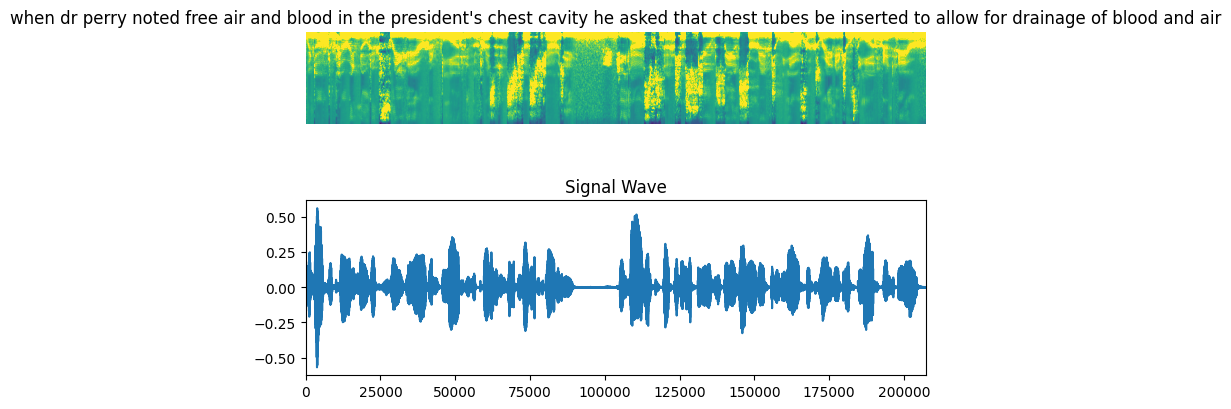

In [10]:
fig = plt.figure(figsize=(8,5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()

## Functions

In [11]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [12]:
# embeds and calculates cosine similarity
# returns matrix of all cosine similaritys
# between s and s1
def get_cos_sim(s, s1, model=minilm):
    embedding_s = model.encode(s, convert_to_tensor=True)
    embedding_s1 = model.encode(s1, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_s, embedding_s1)


# get the diagonals of the cosine matrix
def get_respective_cos_sim(s, s1, model=minilm):
    cos_sim = get_cos_sim(s, s1, model)
    return cos_sim.diagonal()

# smoothing relu so that there will never be
# log of negative number or 0
def relu(x):
    return torch.max(torch.tensor(0.0000001),x)

# custom cosine loss
# the negative log of the cosine similarity
def get_cos_loss(s, s1, model=minilm):
    cos_sim = get_respective_cos_sim(s, s1, model)
    # remove negatives and look at neg loglikilood
    cos_sim = relu(cos_sim).reshape((len(s),1))
    return -np.log(cos_sim.cpu()).numpy()

# decodes set of label
def get_labels(y):
    gt = []
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        gt.append(label)
    return gt

In [13]:
# Normal CTCLoss function
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [14]:
def CTC_Cosine_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_loss = get_cos_loss(y_true_labs, y_pred_labs)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return loss + cos_loss

## Model

In [15]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128, loss=CTCLoss):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=loss, run_eagerly=True)
#     model.compile(optimizer=opt, loss=loss)
    
    return model




In [ ]:
model_base = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
    loss=CTCLoss,
)

In [16]:
model_cos = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=128,
    loss=CTC_Cosine_Loss,
    
)

In [17]:
model_cos.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 97, 32)     128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

In [18]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        avg_cos_dis = get_cos_loss(targets, predictions).mean()
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print(f"Avg. Cos Loss: {avg_cos_dis:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
            print(f"Avg. Cos Loss: {get_cos_loss(targets[i], predictions[i]):.4f}")
            print("-" * 100)
            
            

## Training

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_base = model_base.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history_cos = model_cos.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model_base.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
    break
wer_score = wer(targets, predictions)
avg_cos_dis = get_cos_loss(targets, predictions).mean()
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print(f"Avg. Cos Loss: {avg_cos_dis:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
    print(f"Avg. Cos Loss: {get_cos_loss(targets[i], predictions[i]):.4f}")
    print("-" * 100)


## Testing

In [19]:
gt = []
for X, y in train_dataset:
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        gt.append(label)
    break
gt

["when dr perry noted free air and blood in the president's chest cavity he asked that chest tubes be inserted to allow for drainage of blood and air",
 'baker required fifteen seconds after the simulated shot to ride his motorcycle one hundred eighty to two hundred feet',
 'many rats also come through these socalled ventilators as they open close to the ground at the back of the prison',
 "he concluded however that he could not say whether the four bullets were fired from the revolver in oswald's possession"]

In [70]:
batch_predictions = model_cos.predict(X)
batch_predictions_decoded = decode_batch_predictions(batch_predictions)
batch_predictions_decoded

1/1 [==============================] - 0s 209ms/step


['', '', '', '']

In [71]:
get_labels(y)

['that he never heard oswald express a desire personally to take part in the elimination of injustices anywhere in the world and that he quote',
 'and to give to all a feeling of security as they look toward old age',
 'the walls of babylon were destined to serve still another purpose',
 'and mrs fry with her colleagues still labored assiduously in newgate devoting themselves mainly to the female prison']

In [72]:
get_cos_sim(gt, batch_predictions_decoded)


tensor([[ 0.1080,  0.1080,  0.1080,  0.1080],
        [ 0.0279,  0.0279,  0.0279,  0.0279],
        [ 0.0255,  0.0255,  0.0255,  0.0255],
        [-0.0310, -0.0310, -0.0310, -0.0310]], device='cuda:0')

In [73]:
CTCLoss(y, batch_predictions)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[407.73917],
       [219.01434],
       [205.96193],
       [361.77325]], dtype=float32)>

In [74]:
CTC_Cosine_Loss(y, batch_predictions)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[410.71622],
       [220.84833],
       [209.50151],
       [364.51358]], dtype=float32)>

In [75]:
with tf.GradientTape() as tape:
    # Forward pass
    y_pred = model_cos(X)
    loss = CTC_Cosine_Loss(y, y_pred)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, model_cos.trainable_variables)

model_cos.optimizer.apply_gradients(
    zip(grad, model_cos.trainable_weights)
)


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=99>

In [76]:
loss

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[410.71622],
       [220.84833],
       [209.50151],
       [364.51358]], dtype=float32)>

In [78]:
model_cos.test_step(X)['loss']

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [82]:
epochs = 20
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step, (X,y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = model_cos(X)
            loss = CTC_Cosine_Loss(y, y_pred)

            # Calculate gradients with respect to every trainable variable
            grad = tape.gradient(loss, model_cos.trainable_variables)

            model_cos.optimizer.apply_gradients(
                zip(grad, model_cos.trainable_weights)
            )

            if step % 200 == 0:
                predictions = []
                targets = []
                batch_predictions = model_cos.predict(X)
                batch_predictions = decode_batch_predictions(batch_predictions)
                predictions.extend(batch_predictions)
                targets = get_labels(y)
                wer_score = wer(targets, predictions)
                avg_cos_dis = get_cos_loss(targets, predictions).mean()
                print("-" * 100)
                print(f"Word Error Rate: {wer_score:.4f}")
                print(f"Loss: {loss.numpy().mean():.4f}")
                print(f"Avg. Cos Loss: {avg_cos_dis:.4f}")
                print("-" * 100)
                for i in np.random.randint(0, len(predictions), 2):
                    print(f"Target    : {targets[i]}")
                    print(f"Prediction: {batch_predictions[i]}")
#                     print(targets)
                    print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
#                     print(f"Avg. Cos Loss: {get_cos_loss(targets[i], predictions[i]):.4f}")
                    print("-" * 100)



Start of epoch 0
1/1 [==============================] - 0s 209ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
Loss: 375.6125
Avg. Cos Loss: 6.3987
----------------------------------------------------------------------------------------------------
Target    : baker required fifteen seconds after the simulated shot to ride his motorcycle one hundred eighty to two hundred feet
Prediction: 
Word Error Rate For Example: 1.0000
----------------------------------------------------------------------------------------------------
Target    : he concluded however that he could not say whether the four bullets were fired from the revolver in oswald's possession
Prediction: 
Word Error Rate For Example: 1.0000
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 181ms/step
---------------------------------------------------

1/1 [==============================] - 0s 186ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
Loss: 345.3364
Avg. Cos Loss: 3.7437
----------------------------------------------------------------------------------------------------
Target    : to murphy and elm three times averaging six point five minutes for the three trips
Prediction: th 
Word Error Rate For Example: 1.0000
----------------------------------------------------------------------------------------------------
Target    : and the reason is plain you have taken him from his home and have deprived him of the means of providing himself with the necessaries or comforts of life
Prediction: th 
Word Error Rate For Example: 1.0000
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 162ms/step
----------------------------------------------------------------

1/1 [==============================] - 0s 187ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9630
Loss: 250.9839
Avg. Cos Loss: 6.1069
----------------------------------------------------------------------------------------------------
Target    : afterwards he set up as an insurance broker on his own account but presently failed
Prediction: the
Word Error Rate For Example: 1.0000
----------------------------------------------------------------------------------------------------
Target    : he asked more than once whether the queen was hurt and acknowledged that the pistols were loaded with ball
Prediction: the
Word Error Rate For Example: 0.9474
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 200ms/step
----------------------------------------------------------------------------------------------------
Word Erro

1/1 [==============================] - 0s 214ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9545
Loss: 365.4570
Avg. Cos Loss: 6.6999
----------------------------------------------------------------------------------------------------
Target    : he concluded however that he could not say whether the four bullets were fired from the revolver in oswald's possession
Prediction: he 
Word Error Rate For Example: 0.9500
----------------------------------------------------------------------------------------------------
Target    : many rats also come through these socalled ventilators as they open close to the ground at the back of the prison
Prediction: the 
Word Error Rate For Example: 0.9524
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 211ms/step
------------------------------------------------------------------

1/1 [==============================] - 0s 221ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9882
Loss: 339.9676
Avg. Cos Loss: 9.1520
----------------------------------------------------------------------------------------------------
Target    : to murphy and elm three times averaging six point five minutes for the three trips
Prediction: to
Word Error Rate For Example: 0.9333
----------------------------------------------------------------------------------------------------
Target    : a second will also forged was propounded at doctors commons as that of a mrs hunt of bristol
Prediction: hs 
Word Error Rate For Example: 1.0000
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 183ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
L

1/1 [==============================] - 0s 156ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8519
Loss: 116.9045
Avg. Cos Loss: 1.9137
----------------------------------------------------------------------------------------------------
Target    : additional corroborative evidence
Prediction: an disional coroer di aidens
Word Error Rate For Example: 1.6667
----------------------------------------------------------------------------------------------------
Target    : additional corroborative evidence
Prediction: an disional coroer di aidens
Word Error Rate For Example: 1.6667
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 177ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8793
Loss: 177.7886
Avg. Cos Loss: 2.3476
---------------------

1/1 [==============================] - 0s 184ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8939
Loss: 114.5294
Avg. Cos Loss: 1.9578
----------------------------------------------------------------------------------------------------
Target    : could have reached the president in time to protect him from the second and fatal shot to hit the president
Prediction: co hef reche the presidentin time jo prtectim fromn the sen and fatl shou to het ph presidont
Word Error Rate For Example: 0.7500
----------------------------------------------------------------------------------------------------
Target    : one pair was with the traffic superintendent in london another with an official in folkestone
Prediction: u wen par was with the traixo perantennendt a loundon and nother wi then of ficial in fo sto
Word Error Rate For Example: 1.0000
--------------------------------------------------------------------------

1/1 [==============================] - 0s 211ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.7200
Loss: 92.1288
Avg. Cos Loss: 1.2243
----------------------------------------------------------------------------------------------------
Target    : one hundred and fifty were lodged in a prison just capable of holding fiftytwo
Prediction: un henderd en fifty were lge in a prisin justcacabl ofuldin fiftet
Word Error Rate For Example: 0.7143
----------------------------------------------------------------------------------------------------
Target    : one hundred and fifty were lodged in a prison just capable of holding fiftytwo
Prediction: un henderd en fifty were lge in a prisin justcacabl ofuldin fiftet
Word Error Rate For Example: 0.7143
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 173ms/step
------------------

1/1 [==============================] - 0s 185ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6875
Loss: 70.3483
Avg. Cos Loss: 1.2663
----------------------------------------------------------------------------------------------------
Target    : and others who were present say that no agent was inebriated or acted improperly
Prediction: and olthers who were present say thad noagen was i nebreated er acted emproperely
Word Error Rate For Example: 0.5714
----------------------------------------------------------------------------------------------------
Target    : secret service personnel and facilities
Prediction: secret servise persnel and focilitis
Word Error Rate For Example: 0.6000
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 186ms/step
----------------------------------------------------------------------

1/1 [==============================] - 0s 181ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6706
Loss: 111.1917
Avg. Cos Loss: 1.3387
----------------------------------------------------------------------------------------------------
Target    : and the reason is plain you have taken him from his home and have deprived him of the means of providing himself with the necessaries or comforts of life
Prediction: and the resin the isplin y have tatin imfrom his wom and havdeprie t im of the mens of providin himsel whit the neesaris or concors ofli
Word Error Rate For Example: 0.6552
----------------------------------------------------------------------------------------------------
Target    : oswald met disappointments there just as he had in the past at the outset the soviets told him that he could not remain
Prediction: oswald met disipointmens thear gustice handin the pas atd the at sat the soviestalds him

1/1 [==============================] - 0s 184ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5323
Loss: 60.1959
Avg. Cos Loss: 0.8415
----------------------------------------------------------------------------------------------------
Target    : lined the shores of the rivers with embankments and spanned the rivers with bridges
Prediction: lined the shors of the rivers whithim bantmens and spand the rivers whith briges
Word Error Rate For Example: 0.4286
----------------------------------------------------------------------------------------------------
Target    : three members of this shift separately took this opportunity to visit the cellar coffee house
Prediction: three members of this shift sepertly to this opertonety to vis it the seler cofhy hous
Word Error Rate For Example: 0.5333
----------------------------------------------------------------------------------------------------
1/1 [============

1/1 [==============================] - 0s 188ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4746
Loss: 53.0146
Avg. Cos Loss: 0.5464
----------------------------------------------------------------------------------------------------
Target    : they should gamble with dice or cards and play at bumble puppy or some other disreputable game of chance
Prediction: the should gamble with dice or cars and play bumble puppe or som other dis repedabled gaime of chas
Word Error Rate For Example: 0.4737
----------------------------------------------------------------------------------------------------
Target    : and the great transporting and manufacturing and distributing agencies
Prediction: and the great transporting and manufacturing and destrideting agensees
Word Error Rate For Example: 0.2222
----------------------------------------------------------------------------------------------------
1/1 [===========

1/1 [==============================] - 0s 158ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6296
Loss: 49.5639
Avg. Cos Loss: 0.8967
----------------------------------------------------------------------------------------------------
Target    : afterwards he set up as an insurance broker on his own account but presently failed
Prediction: afterwerds he setoup as in ansuren's broeron his onecete bet presently fal
Word Error Rate For Example: 0.7333
----------------------------------------------------------------------------------------------------
Target    : additional corroborative evidence
Prediction: aditional corrobertive evidence
Word Error Rate For Example: 0.6667
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 174ms/step
-------------------------------------------------------------------------------------

1/1 [==============================] - 0s 162ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5152
Loss: 62.9155
Avg. Cos Loss: 0.6041
----------------------------------------------------------------------------------------------------
Target    : one pair was with the traffic superintendent in london another with an official in folkestone
Prediction: one pare was with the trali suprintend end an london a nother with an aficial inful stom
Word Error Rate For Example: 0.6667
----------------------------------------------------------------------------------------------------
Target    : one pair was with the traffic superintendent in london another with an official in folkestone
Prediction: one pare was with the trali suprintend end an london a nother with an aficial inful stom
Word Error Rate For Example: 0.6667
--------------------------------------------------------------------------------------------------

1/1 [==============================] - 0s 215ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4000
Loss: 47.4031
Avg. Cos Loss: 0.5001
----------------------------------------------------------------------------------------------------
Target    : one hundred and fifty were lodged in a prison just capable of holding fiftytwo
Prediction: one hundred in fifty were loged in a prison just capable of hulding fiftytou
Word Error Rate For Example: 0.2857
----------------------------------------------------------------------------------------------------
Target    : it could have been caused by the telescopic sight of the rifle which was approximately eleven inches long
Prediction: it could ave been cused by the tellescoppeccighte of the wrifle which was aproximately alevin anchus long
Word Error Rate For Example: 0.4444
------------------------------------------------------------------------------------------------

1/1 [==============================] - 0s 185ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3906
Loss: 37.4632
Avg. Cos Loss: 0.3957
----------------------------------------------------------------------------------------------------
Target    : for although the chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the netherlands by a similar process
Prediction: for although the chines tok impressions from woud bloks in graved in relif forcenturies before the wold cuters of the netherlanse by a similar process
Word Error Rate For Example: 0.5000
----------------------------------------------------------------------------------------------------
Target    : and others who were present say that no agent was inebriated or acted improperly
Prediction: and others who were present say that no agent was a ebreated or acted improperly
Word Error Rate For Example: 0.1

1/1 [==============================] - 0s 194ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3385
Loss: 35.1392
Avg. Cos Loss: 0.4381
----------------------------------------------------------------------------------------------------
Target    : he soon arrived at the room where the sheriff was to give a receipt for his body according to the usual custom
Prediction: h suinorived at the room were the sherif was to giv ar receet for his body according to the usual custom
Word Error Rate For Example: 0.3636
----------------------------------------------------------------------------------------------------
Target    : he soon arrived at the room where the sheriff was to give a receipt for his body according to the usual custom
Prediction: h suinorived at the room were the sherif was to giv ar receet for his body according to the usual custom
Word Error Rate For Example: 0.3636
--------------------------------

1/1 [==============================] - 0s 208ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3529
Loss: 39.4828
Avg. Cos Loss: 0.4687
----------------------------------------------------------------------------------------------------
Target    : made by photographing the oswald cards retouching the resulting negatives and producing prints from the retouched negatives
Prediction: made by fhotograting the oswald cards retuching the resulting negetives and producing prints from the reetuched negidives
Word Error Rate For Example: 0.2941
----------------------------------------------------------------------------------------------------
Target    : had no special design or equipment which would have permitted the secret service agent riding in the driver's compartment
Prediction: had no special deigneer acquitment which would have permitted the secret service agent riding in the drivers compartment
Word Error 

1/1 [==============================] - 0s 187ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3529
Loss: 61.7032
Avg. Cos Loss: 0.6034
----------------------------------------------------------------------------------------------------
Target    : and the reason is plain you have taken him from his home and have deprived him of the means of providing himself with the necessaries or comforts of life
Prediction: and the reason is plan you ave taken himfrom his home and have daprived him of the mens of providing himself with the necessaries or conforts af li
Word Error Rate For Example: 0.3103
----------------------------------------------------------------------------------------------------
Target    : to murphy and elm three times averaging six point five minutes for the three trips
Prediction: to murty an el three times averging six point fimeminites for the three trits
Word Error Rate For Example: 0.4667
-

1/1 [==============================] - 0s 192ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2987
Loss: 45.8428
Avg. Cos Loss: 0.3882
----------------------------------------------------------------------------------------------------
Target    : who had been a lodger of his mller had given the cabman's little daughter a jeweler's cardboard box bearing the name of mr death
Prediction: who had been alodgur of his mla had given the cag manslittle daughter a julars pard bord box baring the nae of mr death
Word Error Rate For Example: 0.4167
----------------------------------------------------------------------------------------------------
Target    : governor connally sustained bullet wounds in his back the right side of his chest right wrist and left thigh
Prediction: governor conally sustained bullet wooons in his back the right side of his chest right rist and lef thig
Word Error Rate For Example: 0.2632
-

1/1 [==============================] - 0s 192ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3478
Loss: 44.9357
Avg. Cos Loss: 0.3651
----------------------------------------------------------------------------------------------------
Target    : he saw him empty the gun and throw the shells into some bushes on the southeast corner lot
Prediction: he saw him empty the gon and throw the shells into somebishas on the southeasd corner lote
Word Error Rate For Example: 0.2778
----------------------------------------------------------------------------------------------------
Target    : the secret service has been receiving full cooperation in scientific research and technological development
Prediction: the secret service has been receiving ful cooperation in sientificreserch and teknological develobment
Word Error Rate For Example: 0.3571
-----------------------------------------------------------------------

1/1 [==============================] - 0s 171ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4138
Loss: 55.8058
Avg. Cos Loss: 0.4874
----------------------------------------------------------------------------------------------------
Target    : upstairs in the bedroom a rouleaux box for sovereigns had been broken open
Prediction: austars in the bedroo  rou low box for soverens had been brokon open
Word Error Rate For Example: 0.4615
----------------------------------------------------------------------------------------------------
Target    : upstairs in the bedroom a rouleaux box for sovereigns had been broken open
Prediction: austars in the bedroo  rou low box for soverens had been brokon open
Word Error Rate For Example: 0.4615
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 169ms/step
----------------------


Start of epoch 13
1/1 [==============================] - 0s 189ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2614
Loss: 27.4979
Avg. Cos Loss: 0.1666
----------------------------------------------------------------------------------------------------
Target    : when dr perry noted free air and blood in the president's chest cavity he asked that chest tubes be inserted to allow for drainage of blood and air
Prediction: whe dot pery noted fre r and blood in the presiden's chest cavity he asked that chesttubes be inserted to allow for drainage of blood and air
Word Error Rate For Example: 0.2857
----------------------------------------------------------------------------------------------------
Target    : he concluded however that he could not say whether the four bullets were fired from the revolver in oswald's possession
Prediction: he concluded however that he gud not say whether the forbulets were fir

1/1 [==============================] - 0s 156ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2542
Loss: 28.5791
Avg. Cos Loss: 0.2539
----------------------------------------------------------------------------------------------------
Target    : and that clever schemer sent an elaborate letter of instructions how to ask for the money
Prediction: and that clever scemer sent an a laber at letter of instructions how to ask for the money
Word Error Rate For Example: 0.2500
----------------------------------------------------------------------------------------------------
Target    : sometimes this money might be expended in the purchase of extra articles of food
Prediction: sometimes this money mat be expended in the purchise of extraartacls of food
Word Error Rate For Example: 0.2857
----------------------------------------------------------------------------------------------------
1/1 [====================

1/1 [==============================] - 0s 219ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3382
Loss: 29.5332
Avg. Cos Loss: 0.6321
----------------------------------------------------------------------------------------------------
Target    : an incomplete and fallacious method of preventing contamination
Prediction: and incomplete and follatious methet of preventig cantomination
Word Error Rate For Example: 0.6250
----------------------------------------------------------------------------------------------------
Target    : made by photographing the oswald cards retouching the resulting negatives and producing prints from the retouched negatives
Prediction: made by photograthing the oswald cards retuching the resulting negetives and producing prints from the ree tuched neggitives
Word Error Rate For Example: 0.3529
---------------------------------------------------------------------------------------

1/1 [==============================] - 0s 192ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1765
Loss: 46.8891
Avg. Cos Loss: 0.2163
----------------------------------------------------------------------------------------------------
Target    : oswald met disappointments there just as he had in the past at the outset the soviets told him that he could not remain
Prediction: oswald met disipointmints ther justas he had in the past at the outsait the soviats told him that he could not remain
Word Error Rate For Example: 0.2609
----------------------------------------------------------------------------------------------------
Target    : a second will also forged was propounded at doctors commons as that of a mrs hunt of bristol
Prediction: a second will also forged was prepounded at doctor's commons as that of a mrs hunt of bristal
Word Error Rate For Example: 0.1667
---------------------------------------

1/1 [==============================] - 0s 216ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2338
Loss: 32.5350
Avg. Cos Loss: 0.2601
----------------------------------------------------------------------------------------------------
Target    : who had been a lodger of his mller had given the cabman's little daughter a jeweler's cardboard box bearing the name of mr death
Prediction: who had been a lodger of his mla had given the cabmanslittle daughter a jeelers carbord box baring the name of mr death
Word Error Rate For Example: 0.2500
----------------------------------------------------------------------------------------------------
Target    : who had been a lodger of his mller had given the cabman's little daughter a jeweler's cardboard box bearing the name of mr death
Prediction: who had been a lodger of his mla had given the cabmanslittle daughter a jeelers carbord box baring the name of mr death
Wo

1/1 [==============================] - 0s 132ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1852
Loss: 12.0168
Avg. Cos Loss: 0.1810
----------------------------------------------------------------------------------------------------
Target    : nineteen sixtythree
Prediction: nineteen sixtythree
Word Error Rate For Example: 0.0000
----------------------------------------------------------------------------------------------------
Target    : from which oswald appeared to suffer
Prediction: from which oswald apeared to suffer
Word Error Rate For Example: 0.1667
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 170ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2609
Loss: 32.2472
Avg. Cos Loss: 0.2721
------------------------------------

1/1 [==============================] - 0s 203ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3621
Loss: 49.4992
Avg. Cos Loss: 0.4352
----------------------------------------------------------------------------------------------------
Target    : there was no convincing proof that the accused had administered the poison although beyond question that poison had occasioned the death
Prediction: there was no convincing prof that the acused had administerd the poison although beond question bat poison had occasiond the death
Word Error Rate For Example: 0.2857
----------------------------------------------------------------------------------------------------
Target    : upstairs in the bedroom a rouleaux box for sovereigns had been broken open
Prediction: ustairs in the bedroo  roud lo box for soveens had been brokon open
Word Error Rate For Example: 0.4615
-----------------------------------------------------


Start of epoch 17
1/1 [==============================] - 0s 212ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1705
Loss: 17.1941
Avg. Cos Loss: 0.1318
----------------------------------------------------------------------------------------------------
Target    : many rats also come through these socalled ventilators as they open close to the ground at the back of the prison
Prediction: many rats also comthrough these so called ventolators as they open close to the ground at the back of the prison
Word Error Rate For Example: 0.2381
----------------------------------------------------------------------------------------------------
Target    : many rats also come through these socalled ventilators as they open close to the ground at the back of the prison
Prediction: many rats also comthrough these so called ventolators as they open close to the ground at the back of the prison
Word Error Rate For Example

1/1 [==============================] - 0s 175ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2203
Loss: 20.0362
Avg. Cos Loss: 0.2014
----------------------------------------------------------------------------------------------------
Target    : that calcraft's method of hanging was very rough much the same as if he had been hanging a dog
Prediction: tha calcrafts method of hanging was very wrough much the same as itf he had been hanging a dog
Word Error Rate For Example: 0.2105
----------------------------------------------------------------------------------------------------
Target    : stuckey testified that uncovering oswald's defection was very important quote
Prediction: stucy testified that uncovering oswald's deffection was veryumportant quote
Word Error Rate For Example: 0.4000
----------------------------------------------------------------------------------------------------
1/1 [==============

1/1 [==============================] - 0s 189ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1912
Loss: 21.3860
Avg. Cos Loss: 0.1469
----------------------------------------------------------------------------------------------------
Target    : an incomplete and fallacious method of preventing contamination
Prediction: an incompleete and follacious mehodt of preventing contammination
Word Error Rate For Example: 0.5000
----------------------------------------------------------------------------------------------------
Target    : made by photographing the oswald cards retouching the resulting negatives and producing prints from the retouched negatives
Prediction: made by photograthing the oswald cards retouching the resulting neggetives and producing prints from the retouched negatives
Word Error Rate For Example: 0.1176
-------------------------------------------------------------------------------------

1/1 [==============================] - 0s 201ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2712
Loss: 18.0286
Avg. Cos Loss: 0.2730
----------------------------------------------------------------------------------------------------
Target    : all almost without exception sleep soundly at night except the first after sentence
Prediction: al almost without exception sleep soundly at night excep the first after sentance
Word Error Rate For Example: 0.2308
----------------------------------------------------------------------------------------------------
Target    : our problem is to put to work three and onehalf million employable persons now on the relief rolls
Prediction: our problom is to put to work three and one half milion employable persons now on the reliefros
Word Error Rate For Example: 0.3333
----------------------------------------------------------------------------------------------------
1/

1/1 [==============================] - 0s 208ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1948
Loss: 25.1219
Avg. Cos Loss: 0.1615
----------------------------------------------------------------------------------------------------
Target    : who had been a lodger of his mller had given the cabman's little daughter a jeweler's cardboard box bearing the name of mr death
Prediction: who had been a lodger of his mella had given the cab manslittle daughter a jeelers card bord box bearingd the name of mr death
Word Error Rate For Example: 0.2917
----------------------------------------------------------------------------------------------------
Target    : if oswald left the depository building at twelvethirtythree pm
Prediction: if oswald left the depository building at twelve thirtythree pm
Word Error Rate For Example: 0.2222
---------------------------------------------------------------------------------

1/1 [==============================] - 0s 127ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1852
Loss: 8.7504
Avg. Cos Loss: 0.2267
----------------------------------------------------------------------------------------------------
Target    : the central criminal court when the trial came on
Prediction: the central crimina court when the trilal came on
Word Error Rate For Example: 0.2222
----------------------------------------------------------------------------------------------------
Target    : the central criminal court when the trial came on
Prediction: the central crimina court when the trilal came on
Word Error Rate For Example: 0.2222
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 172ms/step
----------------------------------------------------------------------------------------------------
Word Error